# Exploration of retail dataset
#### by Jérôme d'Harveng

<a id='table'></a>
## Table of Contents
<ul>
<li><a href="#univariate">Univariate exploration</a></li>
<li><a href="#multivariate">Multivariate exploration</a></li>
<li><a href="#RFM">Feature Engineering: RFM Score</a></li>
<li><a href="#exporting">Exporting to csv</a></li>
</ul>

### Loading cleaned dataset and importing libraries

In [1]:
# starting by import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.stats as st
import operator
import datetime as dt

%matplotlib inline

In [2]:
df_sales = pd.read_csv('df_sales_clean.csv', sep=",", encoding='utf_8')
df_segmentation = pd.read_csv('df_segmentation.csv', sep=",", encoding='utf_8')

In [3]:
print("Size df_sales : ", df_sales.shape)
print("Size df_segmentation : ",df_segmentation.shape)

Size df_sales :  (401363, 13)
Size df_segmentation :  (390921, 13)


In [4]:
# sales with cancellation
df_sales.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Month,DayOfMonth,DayOfWeek,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.3,12,1,3,8


In [5]:
# Sales without cancellations
df_segmentation.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Month,DayOfMonth,DayOfWeek,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,12,1,3,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,12,1,3,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,12,1,3,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,12,1,3,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,12,1,3,8


#### Cancelled and non-Cancelled sales

In [6]:
cancelled_sales = df_sales.query('InvoiceNo.str.len()>6')
print(cancelled_sales.shape)
cancelled_sales.query('InvoiceNo.str[0] == "C"').shape[0]

(8872, 13)


8872

In [7]:
non_cancelled = df_sales.query('InvoiceNo.str.len()==6')
print(non_cancelled.shape)
print((cancelled_sales.shape[0]+non_cancelled.shape[0])==df_sales.shape[0])

(392491, 13)
True


<a id='univariate'></a>
## Univariate Exploration

In [8]:
print(df_segmentation.columns.tolist())

['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country', 'Amount', 'Month', 'DayOfMonth', 'DayOfWeek', 'Hour']


### First using Segmentation data (with postive Quantity and UnitPrice)

#### What are the total sales? (without the cancellations)

In [9]:
total_sales = df_segmentation.Amount.sum()
print("The total sales (without the cancellations) are [Sterling] : ", int(total_sales), "Sterling")

The total sales (without the cancellations) are [Sterling] :  8734731 Sterling


#### What about the amount of invoice lines in the different countries?

In [10]:
# In which countries are the sales from this dataset made
country_lines = ((df_segmentation.Country.value_counts()/df_segmentation.shape[0])*100)
print("Here are the different countries for the sales : ")
list_of_countries = df_segmentation.Country.unique()
print(list_of_countries)
print('')
print("Amount of different countries: ", df_segmentation.Country.nunique())
# 5 First countries with most sales expressed in % of total Segmentation dataset
country_lines[:5]

Here are the different countries for the sales : 
['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Finland' 'Austria' 'Greece' 'Singapore' 'Lebanon'
 'United Arab Emirates' 'Israel' 'Saudi Arabia' 'Czech Republic' 'Canada'
 'Brazil' 'USA' 'European Community' 'Bahrain' 'Malta' 'RSA']

Amount of different countries:  36


United Kingdom    89.246676
Germany            2.210933
France             2.051310
EIRE               1.822875
Spain              0.618283
Name: Country, dtype: float64

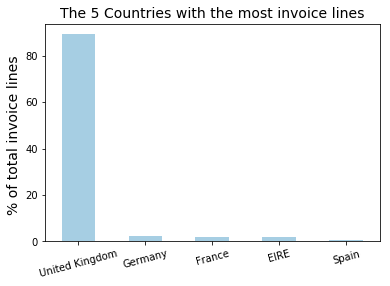

In [96]:
plt.figure(figsize = [6,4])
country_lines[:5].plot(x='index',y='count',kind='bar',colormap='Paired')
plt.xticks(rotation = 15)
plt.title('The 5 Countries with the most invoice lines',fontsize=14)
plt.ylabel('% of total invoice lines ',fontsize=14);

> Almost 90% of the lines are for UK, what's logic, as it's a english compagny

#### Amount of Sales volume per country

In [12]:
country_sales = df_segmentation.groupby(['Country']).sum().Amount

In [13]:
country_sales_prct = ((country_sales.sort_values(ascending=False)/total_sales)*100)
country_sales_prct[:5]

Country
United Kingdom    82.922068
Netherlands        3.250121
EIRE               2.942427
Germany            2.351316
France             2.104265
Name: Amount, dtype: float64

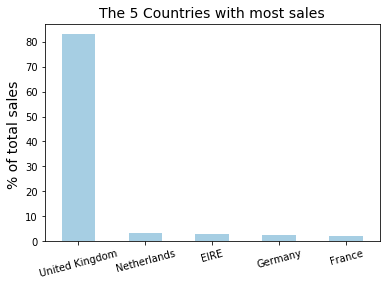

In [98]:
plt.figure(figsize = [6,4])
country_sales_prct[:5].plot(x='index',y='count',kind='bar',colormap='Paired')
plt.xticks(rotation = 15)
plt.title('The 5 Countries with most sales',fontsize=14)
plt.xlabel("")
plt.ylabel('% of total sales ',fontsize=14);

#### What's the average amount per invoice per country

In [15]:
# Group by Country and Invoices
country_avg_inv = df_segmentation.groupby(['Country','InvoiceNo']).mean().Amount

# Compute the average amount of the 
country_avg = {}
for country in list_of_countries:
    country_avg[country]=country_avg_inv[country].mean()

# Sort the countries by average Invoice amount
sorted_x = sorted(country_avg.items(), key=operator.itemgetter(1), reverse=True)

In [16]:
sorted_x[:10]

[('Japan', 552.1535260628685),
 ('Netherlands', 199.0407118750981),
 ('Australia', 124.57190749405397),
 ('Canada', 118.99428726361357),
 ('Sweden', 111.59600749019555),
 ('Finland', 65.26850289013377),
 ('United Kingdom', 65.00015212505124),
 ('Denmark', 58.359438582689855),
 ('EIRE', 52.948618017923536),
 ('Channel Islands', 52.50805785893454)]

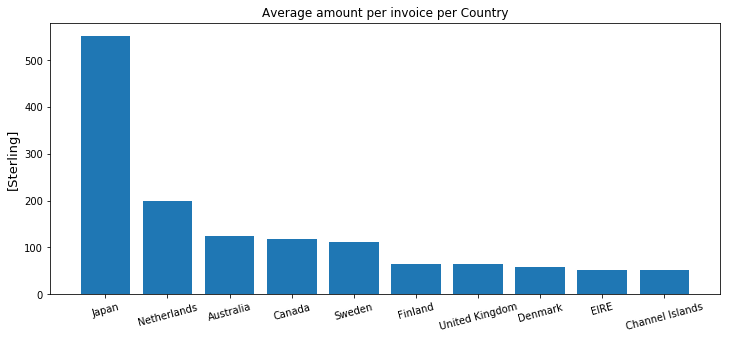

In [93]:
plt.figure(figsize = [12,5])
plt.bar(range(10), [val[1] for val in sorted_x[:10]], align='center')
plt.xticks(range(10), [val[0] for val in sorted_x[:10]])
plt.xticks(rotation=15)
plt.title("Average amount per invoice per Country")
plt.ylabel("[Sterling]",fontsize=13);

#### What's the amount of Customers per country?

In [18]:
customer_country = df_segmentation.groupby('Country').CustomerID.nunique().sort_values(ascending=False)

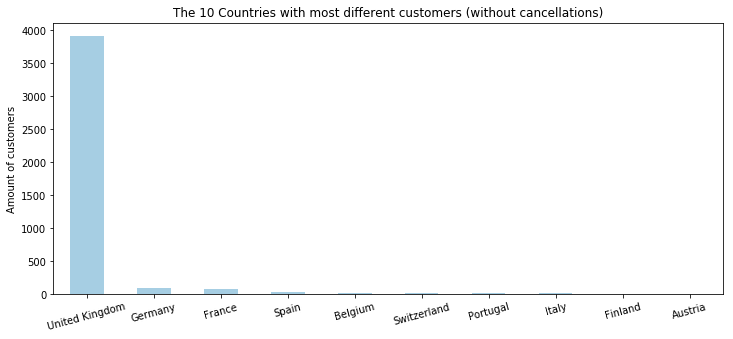

In [19]:
plt.figure(figsize = [12,5])
customer_country[:10].plot(x='index',y='count',kind='bar',colormap='Paired')
plt.xticks(rotation = 15)
plt.title('The 10 Countries with most different customers (without cancellations)')
plt.xlabel("")
plt.ylabel('Amount of customers');

In [20]:
customer_country[:5]

Country
United Kingdom    3917
Germany             94
France              87
Spain               30
Belgium             25
Name: CustomerID, dtype: int64

#### What is the distribution of the UnitPrice 

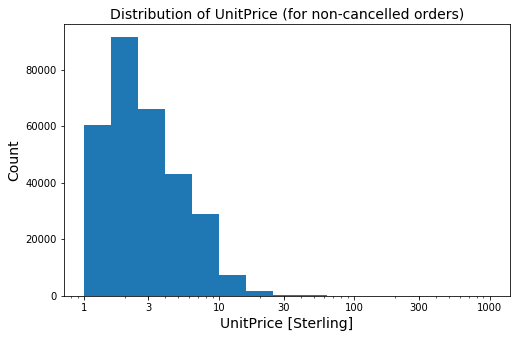

In [100]:
plt.figure(figsize = [8,5])
bins = 10**np.arange(0,3+0.1,0.2)
ticks = [1,3,10,30,100,300,1000]
labels = ['{}'.format(val) for val in ticks]
plt.hist(data = df_segmentation, x = 'UnitPrice', bins = bins)
plt.xscale('log')
plt.xticks(ticks,labels)
plt.xlabel('UnitPrice [Sterling]',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.title('Distribution of UnitPrice (for non-cancelled orders)',fontsize=14);

In [22]:
df_segmentation.UnitPrice.describe()

count    390921.000000
mean          2.874493
std           4.285660
min           0.001000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

> - The distribution of the UnitPrice is Right skewed
> - 75% of the UnitPrices are lower than 3.75 Sterling
> - Most items in this dataset are of lower cost (compared to the max UnitPrice = 8142 Sterling)

#### What's the distribution of Amount

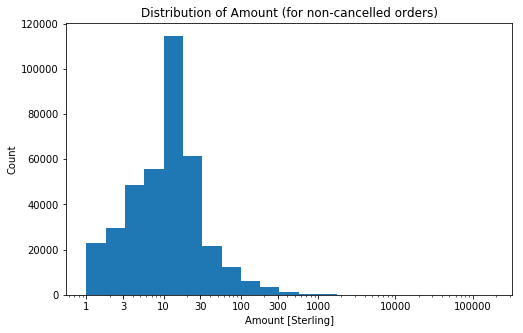

In [23]:
plt.figure(figsize = [8,5])
bins = 10**np.arange(0,5.3+0.1,0.25)
ticks = [1,3,10,30,100,300,1000,10000,100000]
labels = ['{}'.format(val) for val in ticks]
plt.hist(data = df_segmentation, x = 'Amount', bins = bins)
plt.xscale('log')
plt.xticks(ticks,labels)
plt.xlabel('Amount [Sterling]')
plt.ylabel('Count')
plt.title('Distribution of Amount (for non-cancelled orders)');

In [24]:
df_segmentation.Amount.describe()

count    390921.000000
mean         22.343982
std         311.023272
min           0.001000
25%           4.950000
50%          11.900000
75%          19.800000
max      168469.600000
Name: Amount, dtype: float64

> - 75% of the Invoice lines have an amount lower than 19.8 Sterling
> - Max line amount of 168469 Sterling

#### What's the distribution of the quantity?

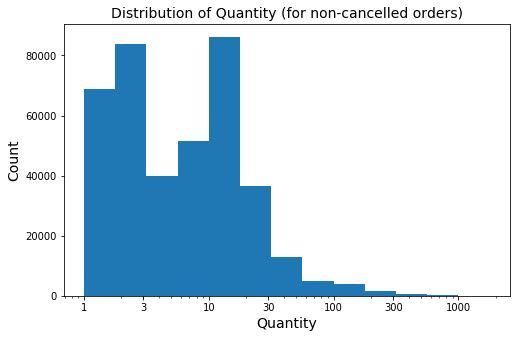

In [109]:
plt.figure(figsize = [8,5])
bins = 10**np.arange(0,3.3+0.1,0.25)
ticks = [1,3,10,30,100,300,1000]
labels = ['{}'.format(val) for val in ticks]
plt.hist(data = df_segmentation, x = 'Quantity', bins = bins)
plt.xscale('log')
plt.xticks(ticks,labels)
plt.xlabel('Quantity',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.title('Distribution of Quantity (for non-cancelled orders)',fontsize=14);

In [26]:
df_segmentation.Quantity.describe()

count    390921.000000
mean         13.148465
std         180.860603
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

#### What is the distribution of the Amount per invoice?

In [27]:
invoice_tot = df_segmentation.groupby('InvoiceNo').sum().Amount

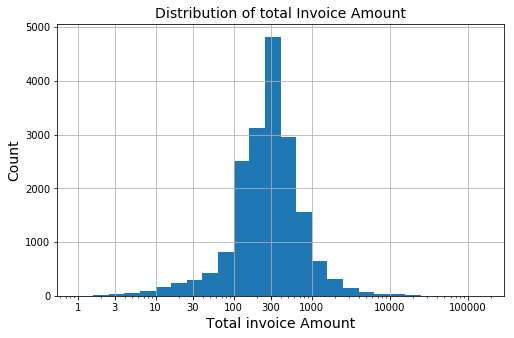

In [110]:
plt.figure(figsize = [8,5])
bins = 10**np.arange(0,5.3+0.1,0.2)
ticks = [1,3,10,30,100,300,1000,10000,100000]
labels = ['{}'.format(val) for val in ticks]
invoice_tot.hist(bins = bins)
plt.xscale('log')
plt.xticks(ticks,labels)
plt.xlabel('Total invoice Amount',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.title('Distribution of total Invoice Amount',fontsize=14);

In [29]:
invoice_tot.describe()

count     18405.000000
mean        474.584725
std        1678.678780
min           0.380000
25%         156.850000
50%         301.600000
75%         463.000000
max      168469.600000
Name: Amount, dtype: float64

#### What's the average number of lines per Invoice?

In [30]:
df_segmentation.groupby('InvoiceNo').count().Amount.describe()

count    18405.000000
mean        21.239935
std         24.350590
min          1.000000
25%          7.000000
50%         15.000000
75%         27.000000
max        541.000000
Name: Amount, dtype: float64

> - On the average there are 21 lines per invoice
> -  50% of the invoices have 15 lines or less
> - 75 % less or equal to 27

#### How much did buy the 10 biggest customers

In [31]:
customer_tot = df_segmentation.groupby('CustomerID').sum().Amount

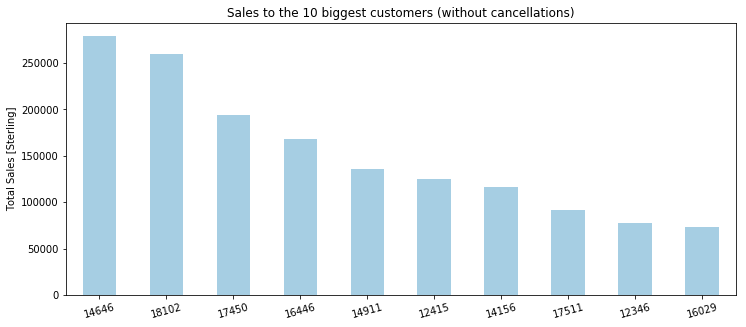

In [32]:
plt.figure(figsize = [12,5])
customer_tot.sort_values(ascending=False)[:10].plot(x='index',y='count',kind='bar',colormap='Paired')
plt.xticks(rotation = 15)
plt.title('Sales to the 10 biggest customers (without cancellations)')
plt.xlabel("")
plt.ylabel('Total Sales [Sterling]');

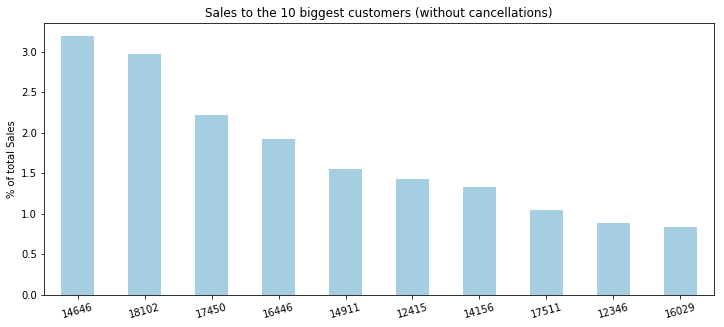

In [33]:
customer_rel = (customer_tot/total_sales)*100
plt.figure(figsize = [12,5])
customer_rel.sort_values(ascending=False)[:10].plot(x='index',y='count',kind='bar',colormap='Paired')
plt.xticks(rotation = 15)
plt.title('Sales to the 10 biggest customers (without cancellations)')
plt.xlabel("")
plt.ylabel('% of total Sales');

In [126]:
# Percentage of total sales, done by the 10 best customers
print(customer_rel.sort_values(ascending=False)[:10].sum())

17.40063853644076


In [34]:
customer_tot.describe()

count      4331.000000
mean       2016.793320
std        8906.718402
min           3.750000
25%         303.950000
50%         663.610000
75%        1632.775000
max      279138.020000
Name: Amount, dtype: float64

> - 50% of the customer buy less than 663.61 Sterling
> - 75% less than 1632.77 Sterling

#### What's the distribution of the sales per Month?

In [35]:
sales_month = df_segmentation.groupby('Month').sum().Amount

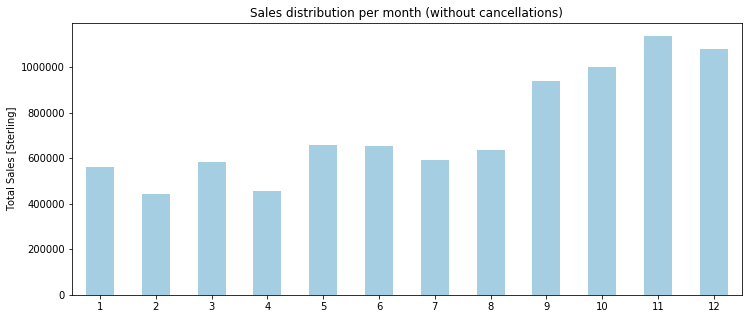

In [36]:
plt.figure(figsize = [12,5])
sales_month.plot(x='index',y='count',kind='bar',colormap='Paired')
plt.xticks(rotation = 0)
plt.title('Sales distribution per month (without cancellations)')
plt.xlabel("")
plt.ylabel('Total Sales [Sterling]');

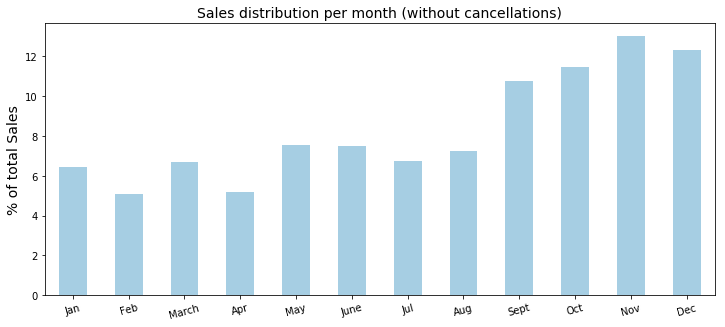

In [142]:
month_index = ['Jan','Feb','March','Apr','May','June','Jul','Aug','Sept','Oct','Nov','Dec']
month_rel = (sales_month/total_sales)*100
month_rel.index = month_index
plt.figure(figsize = [12,5])
month_rel.plot(x='index',y='count',kind='bar',colormap='Paired')
plt.xticks(rotation = 0)
plt.title('Sales distribution per month (without cancellations)',fontsize=14)
plt.xlabel("")
plt.xticks(rotation = 15)
plt.ylabel('% of total Sales',fontsize=14);

#### What's the distribution of the sales per Day of Month?

In [38]:
sales_dOm = df_segmentation.groupby('DayOfMonth').sum().Amount

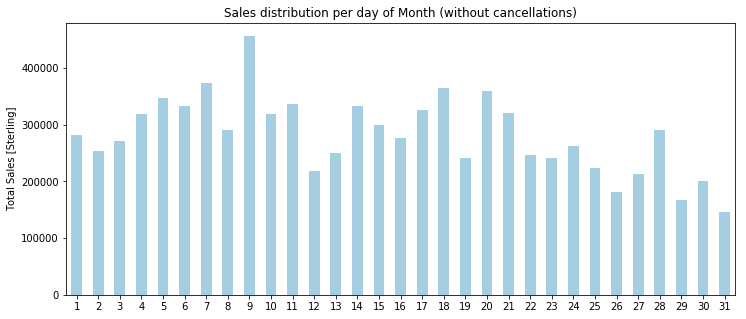

In [39]:
plt.figure(figsize = [12,5])
sales_dOm.plot(x='index',y='count',kind='bar',colormap='Paired')
plt.xticks(rotation = 0)
plt.title('Sales distribution per day of Month (without cancellations)')
plt.xlabel("")
plt.ylabel('Total Sales [Sterling]');

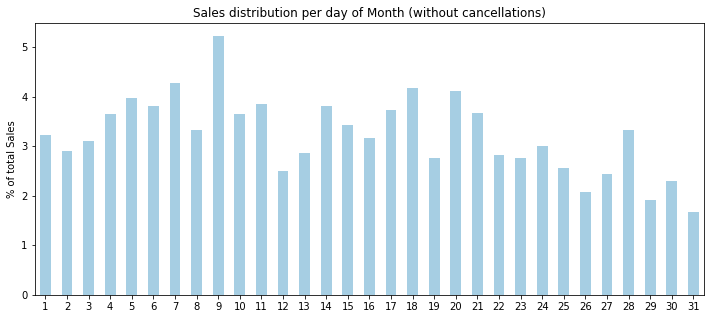

In [40]:
dOm_rel = (sales_dOm/total_sales)*100
plt.figure(figsize = [12,5])
dOm_rel.plot(x='index',y='count',kind='bar',colormap='Paired')
plt.xticks(rotation = 0)
plt.title('Sales distribution per day of Month (without cancellations)')
plt.xlabel("")
plt.ylabel('% of total Sales');

#### What's the distribution of the sales per weekday?

In [41]:
sales_wd  = df_segmentation.groupby('DayOfWeek').sum().Amount

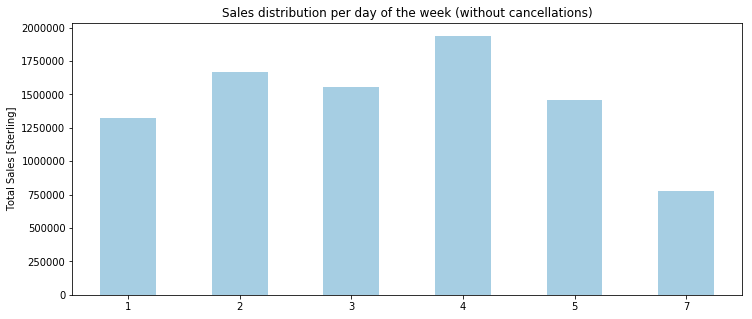

In [42]:
plt.figure(figsize = [12,5])
sales_wd.plot(x='index',y='count',kind='bar',colormap='Paired')
plt.xticks(rotation = 0)
plt.title('Sales distribution per day of the week (without cancellations)')
plt.xlabel("")
plt.ylabel('Total Sales [Sterling]');

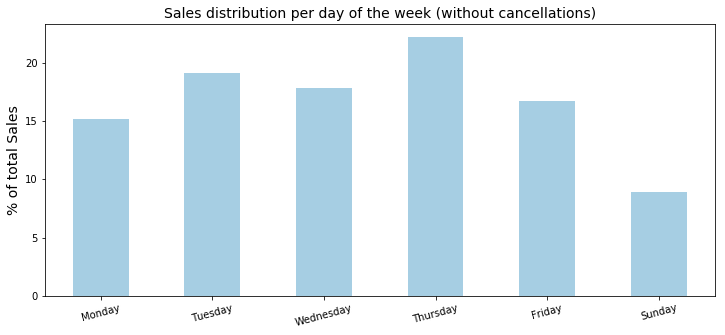

In [144]:
week_index = ['Monday','Tuesday','Wednesday','Thursday','Friday','Sunday']
dOw_rel = (sales_wd/total_sales)*100
dOw_rel.index = week_index
plt.figure(figsize = [12,5])
dOw_rel.plot(x='index',y='count',kind='bar',colormap='Paired')
plt.xticks(rotation = 0)
plt.title('Sales distribution per day of the week (without cancellations)',fontsize=14)
plt.xlabel("")
plt.xticks(rotation = 15)
plt.ylabel('% of total Sales',fontsize=14);

#### What's the distribution of the sales per hour?

In [129]:
sales_h = df_segmentation.groupby('Hour').sum().Amount

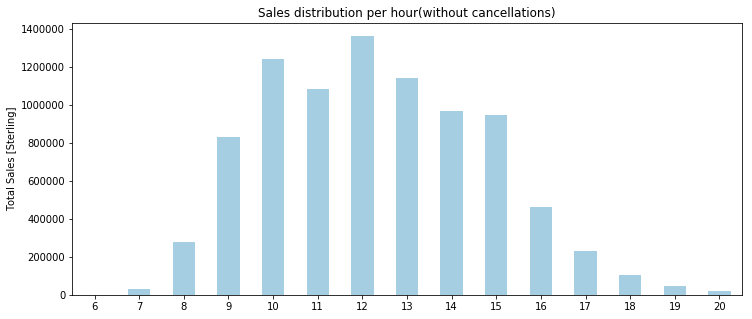

In [134]:
plt.figure(figsize = [12,5])
sales_h.plot(x='index',y='count',kind='bar',colormap='Paired')
plt.xticks(rotation = 0)
plt.title('Sales distribution per hour(without cancellations)')
plt.xlabel("")
plt.ylabel('Total Sales [Sterling]');

In [133]:
sales_h_rel = (sales_h/total_sales)*100

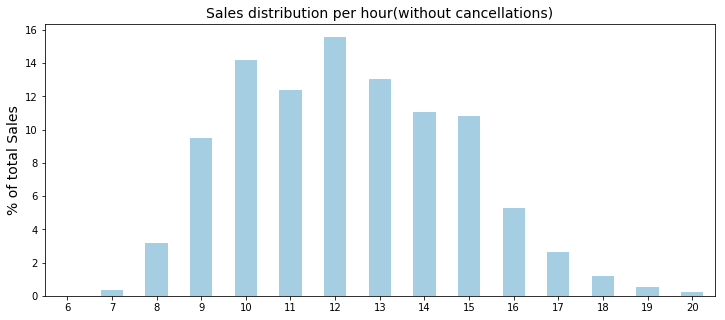

In [135]:
plt.figure(figsize = [12,5])
sales_h_rel.plot(x='index',y='count',kind='bar',colormap='Paired')
plt.xticks(rotation = 0)
plt.title('Sales distribution per hour(without cancellations)',fontsize=14)
plt.xlabel("")
plt.ylabel('% of total Sales',fontsize=14);

### Cancelled Sales

#### What's the total amount of cancelled sales

In [136]:
total_cancelled = cancelled_sales.Amount.sum()
print("The total amount of cancelled sales [Sterling] : ", total_cancelled)

The total amount of cancelled sales [Sterling] :  -608689.47


#### What's the amount of cancelled sales per country?

In [47]:
canc_country = cancelled_sales.groupby('Country').sum().Amount

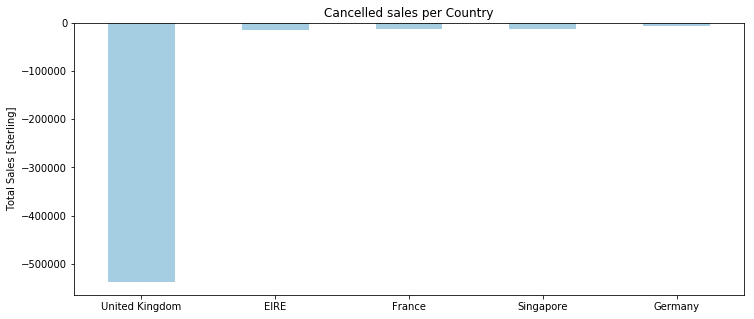

In [48]:
plt.figure(figsize = [12,5])
canc_country.sort_values()[:5].plot(x='index',y='count',kind='bar',colormap='Paired')
plt.xticks(rotation = 0)
plt.title('Cancelled sales per Country')
plt.xlabel("")
plt.ylabel('Total Sales [Sterling]');

#### What's the amount of cancelled sales per Month?

In [49]:
canc_month = cancelled_sales.groupby('Month').sum().Amount

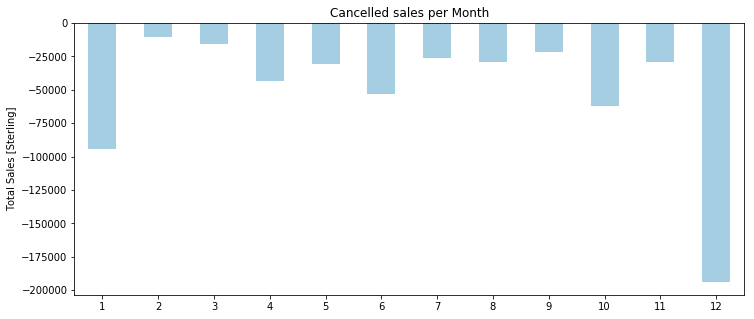

In [50]:
plt.figure(figsize = [12,5])
canc_month.plot(x='index',y='count',kind='bar',colormap='Paired')
plt.xticks(rotation = 0)
plt.title('Cancelled sales per Month')
plt.xlabel("")
plt.ylabel('Total Sales [Sterling]');

In [51]:
rel_month = (canc_month / sales_month )*100

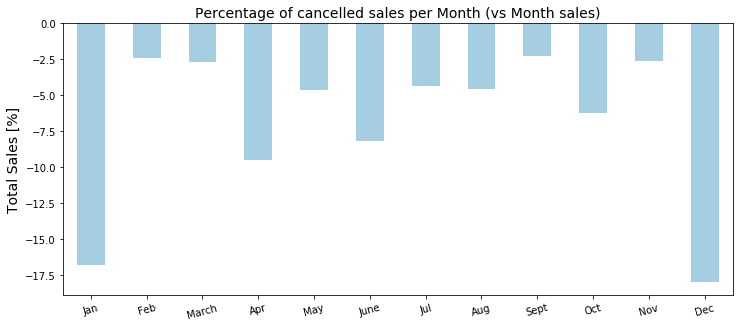

In [145]:
month_index = ['Jan','Feb','March','Apr','May','June','Jul','Aug','Sept','Oct','Nov','Dec']
plt.figure(figsize = [12,5])
rel_month.index = month_index
rel_month.plot(x='index',y='count',kind='bar',colormap='Paired')
plt.xticks(rotation = 0)
plt.title('Percentage of cancelled sales per Month (vs Month sales)',fontsize=14)
plt.xlabel("")
plt.xticks(rotation = 15)
plt.ylabel('Total Sales [%]',fontsize=14);

#### What's the amount of cancelled sales per Day of Week?

In [53]:
canc_dOw = cancelled_sales.groupby('DayOfWeek').sum().Amount

In [54]:
rel_dOw = (canc_dOw/sales_wd)*100

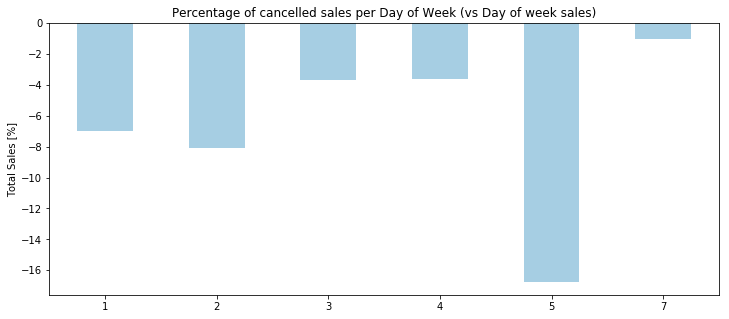

In [55]:
plt.figure(figsize = [12,5])
rel_dOw.plot(x='index',y='count',kind='bar',colormap='Paired')
plt.xticks(rotation = 0)
plt.title('Percentage of cancelled sales per Day of Week (vs Day of week sales)')
plt.xlabel("")
plt.ylabel('Total Sales [%]');

<a id='multivariate'></a>
## Multivariate Exploration
<a href="#table">back to content table</a>

In [56]:
print(df_segmentation.columns.tolist())

['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country', 'Amount', 'Month', 'DayOfMonth', 'DayOfWeek', 'Hour']


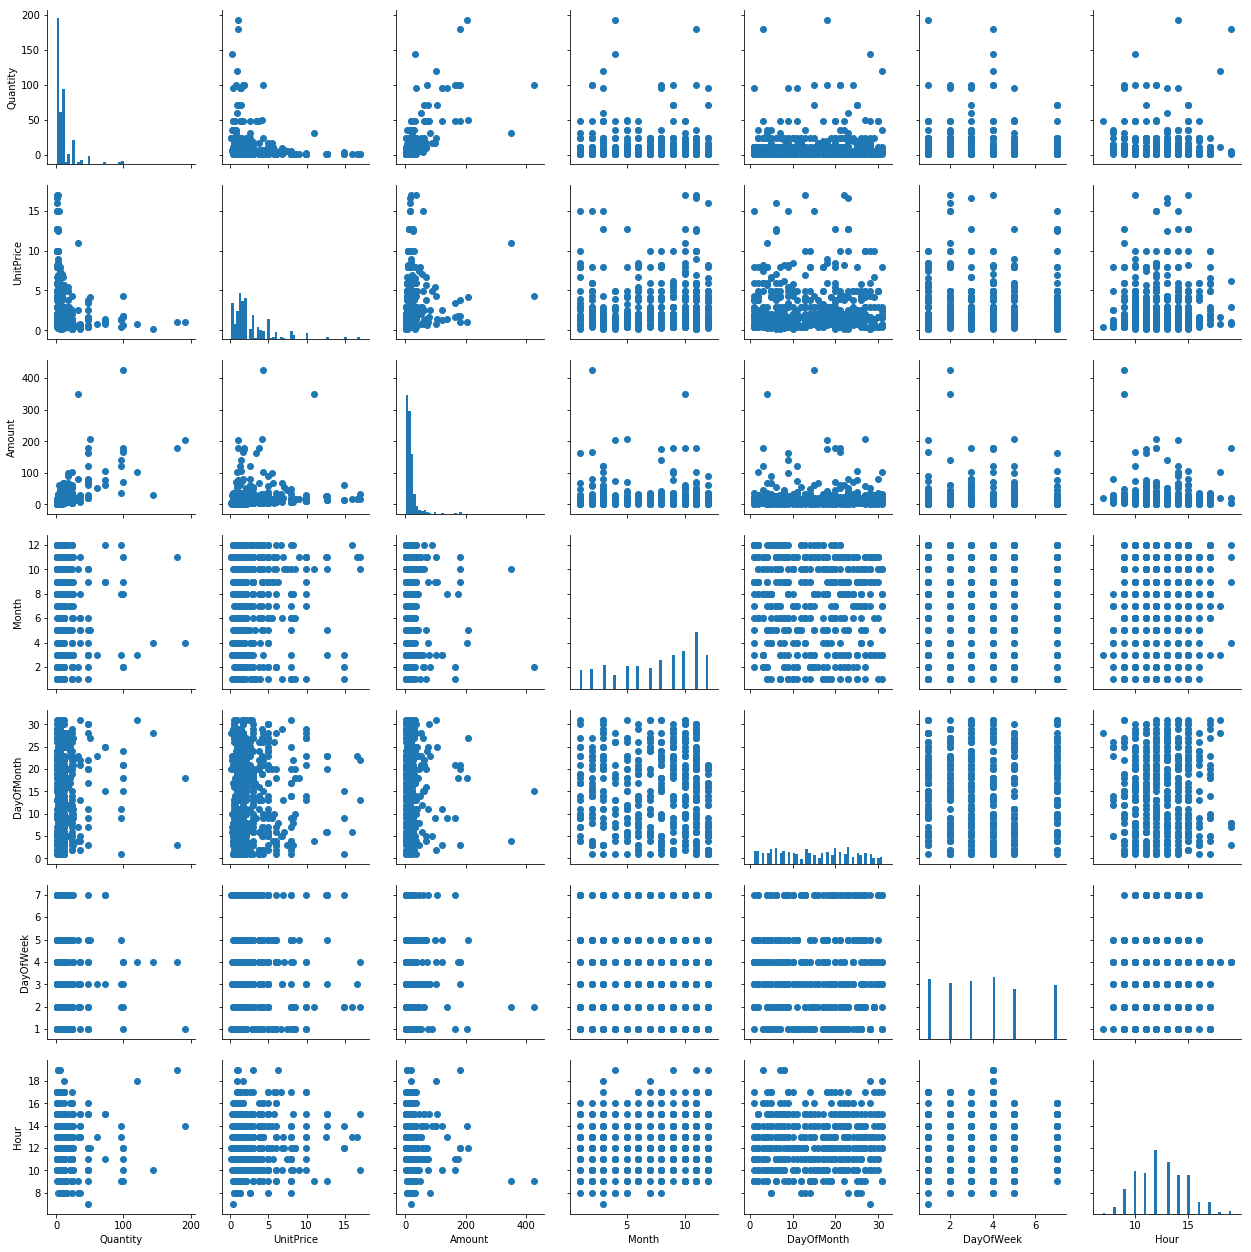

In [57]:
# plot matrix: sample 500 movies so that plots are clearer and
# they render faster

scatter_col = ['Quantity', 'UnitPrice', 'Amount','Month', 'DayOfMonth', 'DayOfWeek', 'Hour']
df_samp = df_segmentation.sample(500)

g = sb.PairGrid(data=df_samp, vars=scatter_col)
g = g.map_diag(plt.hist,bins=50)
g.map_offdiag(plt.scatter);

<a id='RFM'></a>
## RFM Scores
<a href="#table">back to content table</a>

> - **RECENCY (R):** Days since last purchase
> - **FREQUENCY (F):** Total number of purchases
> - **MONETARY VALUE (M):** Total money this customer spent

##### Code

In [58]:
df_segmentation['InvoiceDate'] = pd.to_datetime(df_segmentation['InvoiceDate'])
last_day_df = df_segmentation.InvoiceDate.max()
print(last_day_df)

2011-12-09 12:50:00


In [59]:
# Reference for computation of Recency
TODAY = dt.datetime(2011,12,10)

In [60]:
agg_rule = {'InvoiceDate': lambda x: (TODAY - x.max()).days, 'InvoiceNo': lambda x: len(x),
            'Amount': lambda x: x.sum()}

rfm_score = df_segmentation.groupby('CustomerID').agg(agg_rule)

In [61]:
rfm_score.columns = ["R","F","M"]

In [62]:
print(rfm_score.shape[0])
rfm_score.head(3)

4331


,R,F,M
CustomerID,,,
12346,325,1,77183.60
12347,2,182,4310.00
12348,75,27,1437.24


##### Test

In [63]:
last_inv_date = df_segmentation.query('CustomerID==12348').InvoiceDate.max()
print("Last invoice of customer 12348 was on : ",last_inv_date)
print("Amount of days since last invoice :", (TODAY - last_inv_date).days)
print("Total amount of purchases for customer 12348: ",
      df_segmentation.query('CustomerID==12348').InvoiceNo.shape[0])
print("NB: Amount of distinct invoices: ",df_segmentation.query('CustomerID==12348').InvoiceNo.nunique() )
print("Total amount purchased by customer 12348: ",df_segmentation.query('CustomerID==12348').Amount.sum())

Last invoice of customer 12348 was on :  2011-09-25 13:13:00
Amount of days since last invoice : 75
Total amount of purchases for customer 12348:  27
NB: Amount of distinct invoices:  4
Total amount purchased by customer 12348:  1437.24


### Split the RFM scores using the quantiles

> - The goal is to split **R,F and M** each in 4 parts (from 1 to 4, **1 being the most interesting** and 4 the less
with regards to the e-commerce compagny)
> - To make this separation in 4, we will use the (25%,50% and 75% quantiles)

In [64]:
quantiles = rfm_score.quantile(q=[0.25,0.5,0.75])
quantiles

,R,F,M
0.25,17.0,17.0,303.950
0.50,50.0,41.0,663.610
0.75,142.0,98.0,1632.775


> - **The lower R** (=customer bought not long ago), the better => so category 1 should be if < q25% (4 if > q75%)
> - **The higher F** (=customer buys more often) and **the higher M** (=customer spends more), the better => category 1 would be for if >q75%

##### Code

In [65]:
def Rgroup(x):
    if x <= quantiles['R'].iloc[0]:
        return 1
    elif x <= quantiles['R'].iloc[1]:
        return 2
    elif x <= quantiles['R'].iloc[2]: 
        return 3
    else:
        return 4

In [66]:
def FMgroup(x,type):
    if x <= quantiles[type].iloc[0]:
        return 4
    elif x <= quantiles[type].iloc[1]:
        return 3
    elif x <= quantiles[type].iloc[2]: 
        return 2
    else:
        return 1

In [67]:
rfm_segmentation = rfm_score
rfm_segmentation.head(1)

,R,F,M
CustomerID,,,
12346,325,1,77183.6


In [68]:
rfm_segmentation['R_segments'] = rfm_segmentation['R'].apply(Rgroup)

In [69]:
rfm_segmentation['F_segments'] = rfm_segmentation['F'].apply(FMgroup,args=('F'))
rfm_segmentation['M_segments'] = rfm_segmentation['M'].apply(FMgroup,args=('M'))

##### Test

In [70]:
print(quantiles)
rfm_segmentation.head(3)

          R     F         M
0.25   17.0  17.0   303.950
0.50   50.0  41.0   663.610
0.75  142.0  98.0  1632.775


,R,F,M,R_segments,F_segments,M_segments
CustomerID,,,,,,
12346,325,1,77183.60,4,4,1
12347,2,182,4310.00,1,1,1
12348,75,27,1437.24,3,3,2


#### Let's group the different segments in 1 column

In [71]:
rfm_segmentation['RFM_score'] = rfm_segmentation['R_segments']*100 + rfm_segmentation['F_segments']*10\
                                + rfm_segmentation['M_segments']
            

In [72]:
# for ease of manipulation afterwards, conversion of RFM_score into String values
rfm_segmentation['RFM_score'] = rfm_segmentation['RFM_score'].astype(str)

In [73]:
# Test
print(rfm_segmentation.iloc[0,-1])
print(rfm_segmentation.iloc[0,-1][0])
rfm_segmentation.head(5)

441
4


,R,F,M,R_segments,F_segments,M_segments,RFM_score
CustomerID,,,,,,,
12346,325,1,77183.60,4,4,1,441
12347,2,182,4310.00,1,1,1,111
12348,75,27,1437.24,3,3,2,332
12349,18,72,1457.55,2,2,2,222
12350,310,16,294.40,4,4,4,444


##### Top 5 best customers 

In [74]:
rfm_segmentation.query('RFM_score=="111"').sort_values(by='M',ascending=False).head(5)

,R,F,M,R_segments,F_segments,M_segments,RFM_score
CustomerID,,,,,,,
14646,1,2060,279138.02,1,1,1,111
18102,0,431,259657.30,1,1,1,111
17450,8,336,194390.79,1,1,1,111
14911,1,5584,136161.83,1,1,1,111
14156,9,1382,116560.08,1,1,1,111


##### Customer Segments

> based on https://towardsdatascience.com/find-your-best-customers-with-customer-segmentation-in-python-61d602f9eee6
we'll cluster the our Customer into 8 segments
 -  **Best Customers: 111**, Bought most recently and most often, and spend the most
 -  **Loyal Customers: X1X**, Buy most frequently
 -  **Big Spenders: XX1**, Spend the most
 -  **Almost Lost: 311**, Haven't purchased for some time, but purchased frequently and spend the most
 -  **Lost Customers: 411**, Haven't purchased for some time, but purchased frequently and spend the most
 -  **Lost Cheap Customers: 444**, Last purchased long ago, purchased few, and spend little

### Before exporting rfm_segmentation, adding extra info

In [75]:
print(rfm_segmentation.columns.tolist())
print(df_segmentation.columns.tolist())

['R', 'F', 'M', 'R_segments', 'F_segments', 'M_segments', 'RFM_score']
['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country', 'Amount', 'Month', 'DayOfMonth', 'DayOfWeek', 'Hour']


#### Add the country

In [76]:
# Customer vs Country
country_link = df_segmentation.groupby('CustomerID')['Country'].first()
country_link.head(3)

CustomerID
12346    United Kingdom
12347           Iceland
12348           Finland
Name: Country, dtype: object

In [77]:
# reset index of rfm_segmentation
rfm_index = rfm_segmentation.copy()
rfm_index = rfm_index.reset_index()
print(rfm_index.shape)

(4331, 8)


In [78]:
rfm_index['Country'] =  rfm_index.CustomerID.apply(lambda x: country_link.loc[x])

In [79]:
rfm_index.head(3)

,CustomerID,R,F,M,R_segments,F_segments,M_segments,RFM_score,Country
0,12346,325,1,77183.60,4,4,1,441,United Kingdom
1,12347,2,182,4310.00,1,1,1,111,Iceland
2,12348,75,27,1437.24,3,3,2,332,Finland


In [80]:
rfm_index.query('CustomerID==12583')

,CustomerID,R,F,M,R_segments,F_segments,M_segments,RFM_score,Country
188,12583,2,232,6705.38,1,1,1,111,France


#### Number of distinct items bought by Customer

In [81]:
# Customer vs Distinc items bought
item_link = df_segmentation.groupby('CustomerID')['StockCode'].nunique()
item_link.head(3)

CustomerID
12346      1
12347    103
12348     21
Name: StockCode, dtype: int64

In [82]:
rfm_index['NuniqueProd'] = rfm_index.CustomerID.apply(lambda x: item_link.loc[x])

In [83]:
rfm_index.head(3)

,CustomerID,R,F,M,R_segments,F_segments,M_segments,RFM_score,Country,NuniqueProd
0,12346,325,1,77183.60,4,4,1,441,United Kingdom,1
1,12347,2,182,4310.00,1,1,1,111,Iceland,103
2,12348,75,27,1437.24,3,3,2,332,Finland,21


In [141]:
rfm_index[['CustomerID', 'R', 'F', 'M', 'NuniqueProd']].sample(5)

,CustomerID,R,F,M,NuniqueProd
536,13052,212,18,348.15,18
1387,14234,22,147,754.12,122
3348,16918,49,128,1068.82,97
3890,17677,1,303,16345.38,178
2098,15214,1,110,1661.44,109


<a id='exporting'></a>
### Exporting Cleaned data in csv
<a href="#table">Back to table of content</a>

In [86]:
df_segmentation.to_csv('df_RFM_labels.csv', encoding='utf_8', index=False)

In [87]:
rfm_index.to_csv('RFM_index.csv', encoding='utf_8', index=False)